### Point Similarity Results: Upsample Anything vs. AnyUP

Upsample Anything method denoises the feature maps and encourages coherent grouping of object regions, leading to tighter object-level binding.


In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F

from upsample_anything import UPA, dinov2_infer
from utils import cal_similarity, visualize_sim

device = "cuda" if torch.cuda.is_available() else "cpu"


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:58: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/nas/k8s/dev/research/ytoh96/zeoshot_stiching/Upsample-Anything_Pytorch/src/upsample_anything.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/nas/k8s/dev/research/ytoh96/zeoshot_stiching/Upsample-Anything_Pytorch/src/upsample_anything.py:27

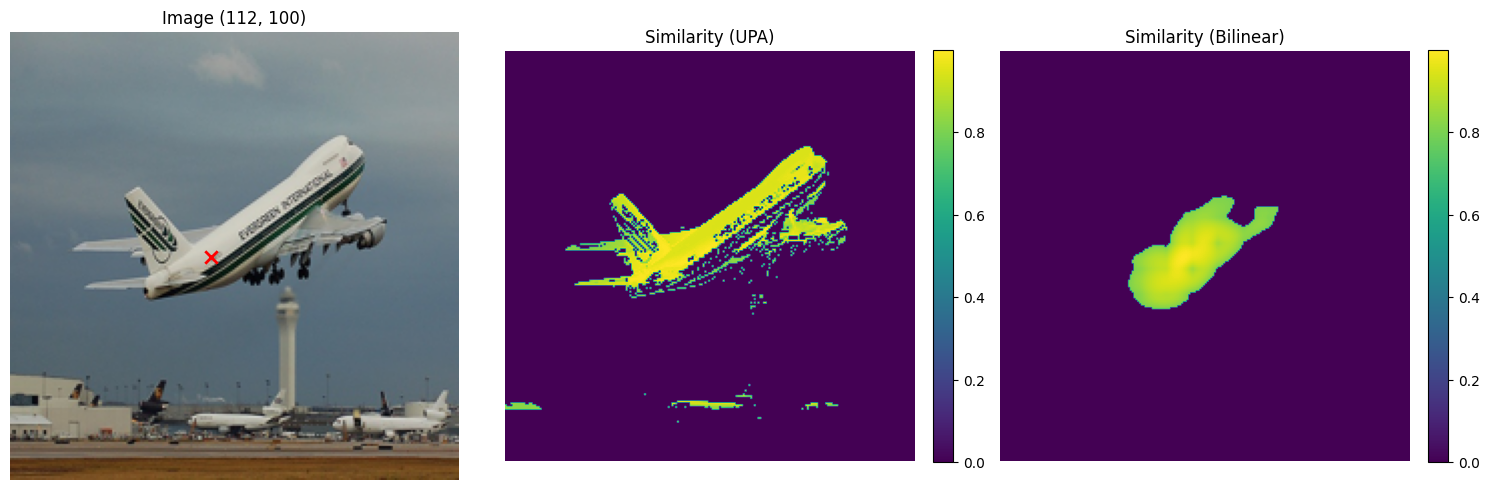

In [2]:
img_path = "../img/airplane2.jpg"
img = Image.open(img_path).convert("RGB").resize((224, 224), Image.BICUBIC)

# ▶ DINOv2 feature (14x14)
lr_feature = dinov2_infer(img)

# ▶ Our method (UPA)
hr_feature = UPA(img, lr_feature)   # [1, C, 224, 224]

# ▶ Bilinear upsampling
bl_feature = F.interpolate(lr_feature, size=(224, 224), mode="bilinear", align_corners=False)

point = (112, 100)

# ▶ similarity maps
sim_upa = cal_similarity(hr_feature, img, point=point)
sim_bilinear = cal_similarity(bl_feature, img, point=point)

sim_upa[sim_upa < 0.8] = 0
sim_bilinear[sim_bilinear < 0.8] = 0

visualize_sim(img, point, sim_upa, sim_bilinear)


### AnyUp

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /root/.cache/torch/hub/wimmerth_anyup_main
Downloading: "https://github.com/wimmerth/anyup/releases/download/checkpoint/anyup_paper.pth" to /root/.cache/torch/hub/checkpoints/anyup_paper.pth
100%|██████████| 3.38M/3.38M [00:00<00:00, 72.1MB/s]


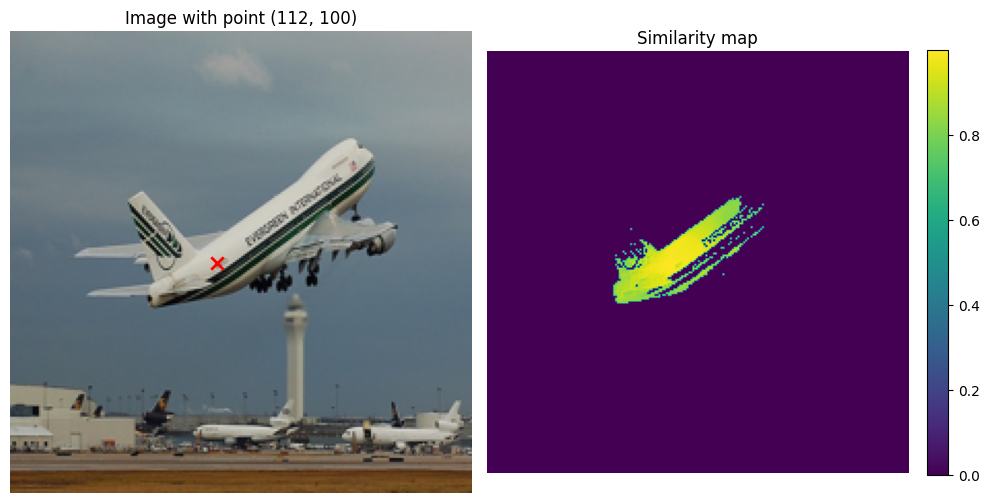

In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms


img_path = "../img/airplane2.jpg"
img = Image.open(img_path).convert("RGB").resize((224, 224), Image.BICUBIC)

lr_feature2 = dinov2_infer(img)  


to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])
img_tensor = to_tensor(img).unsqueeze(0).to(device)  # (1,3,224,224)

upsampler = torch.hub.load('wimmerth/anyup', 'anyup').to(device).eval()

with torch.no_grad():
    hr_anyup = upsampler(
        image=img_tensor,        # tensor (1,3,224,224)
        features=lr_feature2,    # (1,C,16,16)
        output_size=(224,224)
    )                           # → (1,384,224,224)

sim_map = cal_similarity(
    hr_anyup,   # [1, C, 224, 224]
    img,          # 
    point=point
)

sim_map[sim_map < 0.8] = 0

py, px = point  
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].scatter(px, py, marker='x', s=80, linewidths=2, color='red')
axes[0].set_title(f"Image with point ({py}, {px})")
axes[0].axis("off")

im = axes[1].imshow(sim_map, cmap="viridis")
axes[1].set_title("Similarity map")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()